# 0. 한국어 데이터로 챗봇 만들기

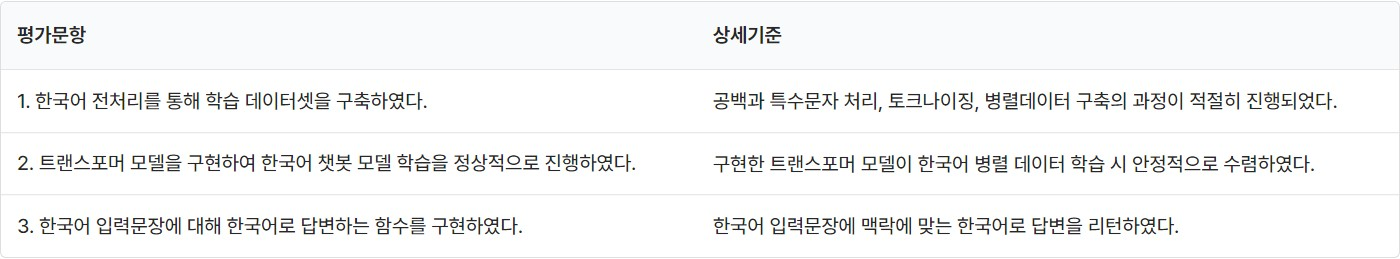

In [53]:
import os, re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from konlpy.tag import Okt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.callbacks import EarlyStopping

# 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

In [54]:
chat_file_path = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData.csv'

data = pd.read_csv(chat_file_path)
data


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


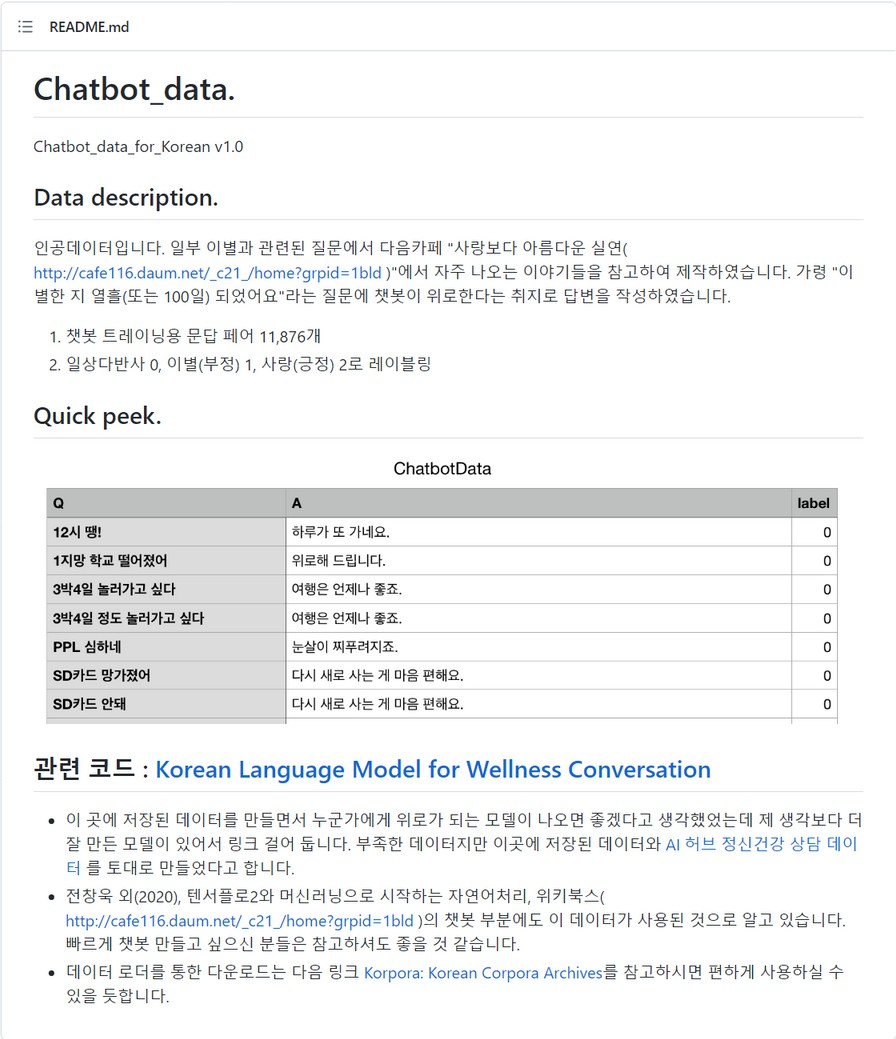

# 2. 데이터 전처리하기(루브릭1)

In [55]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z\u3131-\u3163\uAC00-\uD7A30-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [56]:
def load_conversations():
    inputs = [preprocess_sentence(datum[0]) for datum in data.iloc]
    outputs = [preprocess_sentence(datum[1]) for datum in data.iloc]
        
    return inputs, outputs

In [57]:
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))  
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [58]:
print('questions:', questions[: 10], sep='\n')
print('answers:', answers[: 10], sep='\n')

questions:
['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네', 'sd카드 망가졌어', 'sd카드 안돼', 'sns 맞팔 왜 안하지ㅠㅠ', 'sns 시간낭비인 거 아는데 매일 하는 중', 'sns 시간낭비인데 자꾸 보게됨']
answers:
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .', '다시 새로 사는 게 마음 편해요 .', '다시 새로 사는 게 마음 편해요 .', '잘 모르고 있을 수도 있어요 .', '시간을 정하고 해보세요 .', '시간을 정하고 해보세요 .']


In [59]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


공백과 특수문자 처리, 토크나이징이 적절히 진행되었다.

# 3. SubwordTextEncoder 사용하기(루브릭1)

In [60]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(\
    questions + answers, target_vocab_size=2 ** 12) # ★
print(tokenizer)


<SubwordTextEncoder vocab_size=4041>


In [61]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [62]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [4041]
END_TOKEN의 번호 : [4042]


In [63]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

4043


In [64]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 22번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 22번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 22번째 질문 샘플: [49, 118, 737, 1200, 3817, 64, 1714]
정수 인코딩 후의 22번째 답변 샘플: [3699, 337, 492, 16, 3459, 665, 1]


질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.9409625306605767
대답의 최소 길이 : 1
대답의 최대 길이 : 24
대답의 평균 길이 : 4.716146494121627


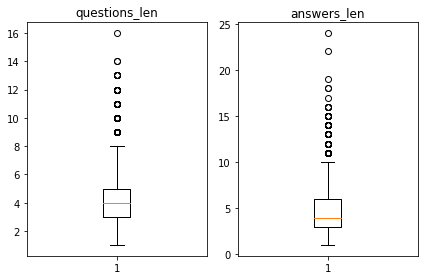

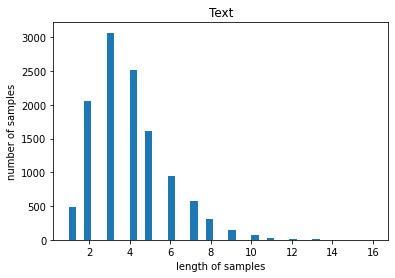

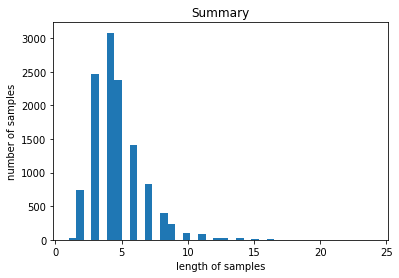

In [65]:
# 길이 분포 출력
questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]

print('질문의 최소 길이 : {}'.format(np.min(questions_len)))
print('질문의 최대 길이 : {}'.format(np.max(questions_len)))
print('질문의 평균 길이 : {}'.format(np.mean(questions_len)))
print('대답의 최소 길이 : {}'.format(np.min(answers_len)))
print('대답의 최대 길이 : {}'.format(np.max(answers_len)))
print('대답의 평균 길이 : {}'.format(np.mean(answers_len)))

plt.subplot(1,2,1)
plt.boxplot(questions_len)
plt.title('questions_len')
plt.subplot(1,2,2)
plt.boxplot(answers_len)
plt.title('answers_len')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [66]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 2 ** 4 # ★

In [67]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs


In [68]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 4043
필터링 후의 질문 샘플 개수: 11341
필터링 후의 답변 샘플 개수: 11341


In [69]:
questions_train, questions_valid, answers_train, answers_valid = train_test_split(\
    questions, answers, test_size=0.2, random_state=9)


In [70]:
questions_train

array([[4041, 2000,  373, ...,    0,    0,    0],
       [4041,  798, 1310, ...,    0,    0,    0],
       [4041,   25,  633, ...,    0,    0,    0],
       ...,
       [4041,  785, 1594, ...,    0,    0,    0],
       [4041,  888, 4020, ...,    0,    0,    0],
       [4041,  916, 1129, ...,    0,    0,    0]], dtype=int32)

In [71]:
BATCH_SIZE = 2 ** 6

In [72]:
# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
train = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions_train,
        'dec_inputs': answers_train[:, :-1]
    },
    {
        'outputs': answers_train[:, 1:]
    },
))

train = train.cache()
train = train.batch(BATCH_SIZE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

train

<PrefetchDataset shapes: ({inputs: (None, 16), dec_inputs: (None, 15)}, {outputs: (None, 15)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

In [73]:
valid = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions_valid,
        'dec_inputs': answers_valid[:, :-1]
    },
    {
        'outputs': answers_valid[:, 1:]
    },
))

valid = valid.cache()
valid = valid.batch(BATCH_SIZE)
valid = valid.prefetch(tf.data.experimental.AUTOTUNE)

valid

<PrefetchDataset shapes: ({inputs: (None, 16), dec_inputs: (None, 15)}, {outputs: (None, 15)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

병렬데이터 구축의 과정이 적절히 진행되었다.

# 4. 모델 구성하기(루브릭2)

## 4.1. 레이어 구성하기

In [74]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
 
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [75]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    
    return output

In [76]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs
    

In [77]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [78]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)


In [79]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [80]:
def encoder(vocab_size,
             num_layers,
             units,
             d_model,
             num_heads,
             dropout,
             name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [81]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


In [82]:
def decoder(vocab_size,
             num_layers,
             units,
             d_model,
             num_heads,
             dropout,
             name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


## 4.2. 트랜스포머 모델 구성하기

In [83]:
def transformer(vocab_size,
                 num_layers,
                 units,
                 d_model,
                 num_heads,
                 dropout,
                 name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [84]:
tf.keras.backend.clear_session()

# 하이퍼파라미터 ★
NUM_LAYERS = 2 ** 2 # 인코더와 디코더의 층의 개수
D_MODEL = 2 ** 8 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 2 ** 3 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 2 ** 10 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 2 ** -3 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4194048     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 4.3. 모델 훈련하기

In [85]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [86]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

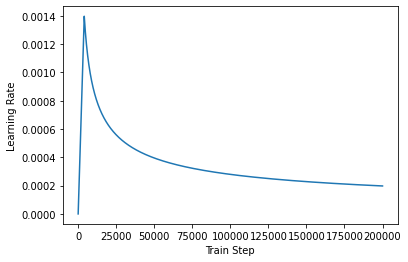

In [87]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [88]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [89]:
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

EPOCHS = 2 ** 4 # ★
history = model.fit(train, epochs=EPOCHS, verbose=1, callbacks=[early_stop], validation_data=valid)


Epoch 1/16
142/142 [==============================] - 21s 73ms/step - loss: 3.8633 - accuracy: 0.0517 - val_loss: 3.5772 - val_accuracy: 0.0644
Epoch 2/16
142/142 [==============================] - 8s 57ms/step - loss: 3.2916 - accuracy: 0.1194 - val_loss: 3.0469 - val_accuracy: 0.1297
Epoch 3/16
142/142 [==============================] - 8s 57ms/step - loss: 2.8849 - accuracy: 0.1327 - val_loss: 2.7793 - val_accuracy: 0.1408
Epoch 4/16
142/142 [==============================] - 8s 57ms/step - loss: 2.7011 - accuracy: 0.1412 - val_loss: 2.6661 - val_accuracy: 0.1451
Epoch 5/16
142/142 [==============================] - 8s 57ms/step - loss: 2.5758 - accuracy: 0.1488 - val_loss: 2.5556 - val_accuracy: 0.1523
Epoch 6/16
142/142 [==============================] - 8s 58ms/step - loss: 2.4438 - accuracy: 0.1562 - val_loss: 2.4510 - val_accuracy: 0.1589
Epoch 7/16
142/142 [==============================] - 8s 58ms/step - loss: 2.3100 - accuracy: 0.1653 - val_loss: 2.3599 - val_accuracy: 0.166

In [90]:
def history_plot(history):
    y_acc = history.history['accuracy']
    y_vacc = history.history['val_accuracy']
    
    y_loss = history.history['loss']
    y_vloss = history.history['val_loss']

    epochs_range = range(len(y_acc))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, y_acc, marker='.', label="Train-set accuracy")
    plt.plot(epochs_range, y_vacc, marker='.', label="Validation-set accuracy")
    plt.legend(loc='lower right')
    plt.grid()
    plt.title('Accurcy graph with batch normalization') 
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, y_loss, marker='.', label="Train-set Loss")
    plt.plot(epochs_range, y_vloss, marker='.', label="Validation-set Loss")
    plt.legend(loc='upper right')
    plt.grid()
    plt.title('Loss graph with batch normalization') 
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.show()

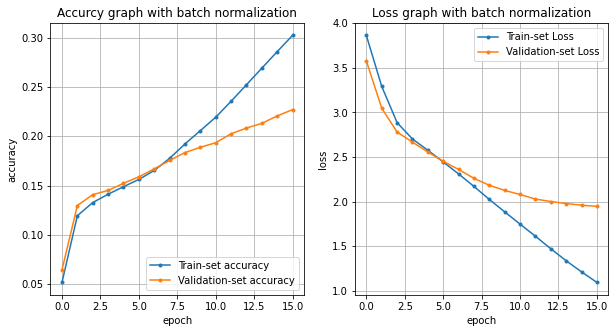

In [91]:
history_plot(history)

구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.

# 5. 모델 평가하기(루브릭3)

In [92]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [93]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [94]:
sentence_generation('어디에 있었어?')

입력 : 어디에 있었어?
출력 : 그건 좀 아닌 거 같아요 .


'그건 좀 아닌 거 같아요 .'

In [95]:
sentence_generation('그건 함정이야.')

입력 : 그건 함정이야.
출력 : 마음에게 지워질 거예요 .


'마음에게 지워질 거예요 .'

In [96]:
sentence_generation('너는 누구야?')

입력 : 너는 누구야?
출력 : 저는 위로봇입니다 .


'저는 위로봇입니다 .'

In [97]:
sentence_generation('나는 누구야?')

입력 : 나는 누구야?
출력 : 저는 위로봇입니다 .


'저는 위로봇입니다 .'

한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.

# 6. 회고하기

## 6.1. 이번 프로젝트에서 어려웠던 점

내용 자체는 이해할 수 있지만 코드로 구현하는 부분이 매우 어려웠고,  
결과도 만족스럽지 않아서 여러 모델을 만들어 보느라 시간이 많이 소모되었다.

## 6.2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

원래는 val_accuray만 높으면 결과도 좋기 마련인데  
이번 프로젝트는 val_accuracy가 더 낮은데도 불구하고 오히려 대답을 잘 하는 경우가 많았다.  
챗봇이 감성 분석이나 번역기와는 결이 다르게 어려운 것 같다.

## 6.3. 루브릭 평가 지표를 맞추기 위해 시도한 것들

특수문자에 한글과 숫자를 추가했고 SubwordTextEncoder로 토크나이징을 했다.

단순 복붙만 했는데도 모델이 훈련이 잘 수행됐다.

대답은 잘 하지는 못하는 것 같다.

## 6.4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

3번 평가문항이 조금 어려웠던 것 같다. 같은 퍼래머더라도 다시 돌리면 또 달라지기도 한다.

## 6.5. 자기 다짐

벌써 방학 이틀이 지나갔다. 내일부터는 빡공이다.

# 7. 참고 사이트

https://datascienceschool.net/03%20machine%20learning/03.01.02%20KoNLPy%20%ED%95%9C%EA%B5%AD%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html